# DQN in CartPole-v1 environments

**Install Required Packages & Set Up the CartPole-v1 Environment**

In [10]:
#Install Required Packages
!pip3 install gymnasium[classic_control]

In [11]:
#Import required modules
import gymnasium as gym
import math
import random
import matplotlib
import matplotlib.pyplot as plt
import numpy as np

#Import necessary classes and function
from collections import namedtuple, deque
from itertools import count

#Import PyTorch modules
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

#Creating CartPole-v1 environment
env = gym.make("CartPole-v1")

#Set up matplotlib
is_ipython = 'inline' in matplotlib.get_backend()
if is_ipython:
    from IPython import display

#Turn on interactive mode
plt.ion()

#if GPU is to be used
device = torch.device(
    "cuda" if torch.cuda.is_available() else
    "mps" if torch.backends.mps.is_available() else
    "cpu"
)

**Memory: Save the data to reuse later**

In [12]:
Transition = namedtuple('Transition',
                        ('state', 'action', 'next_state', 'reward'))

#Store past experiences for training
class ReplayMemory(object):

    def __init__(self, capacity):
        #Initialize a deque to store experience tuples with a fixed capacity
        self.memory = deque([], maxlen=capacity)

    def push(self, *args):
        #Save a transition to memory
        self.memory.append(Transition(*args))

    def sample(self, batch_size):
        #Randomly sample a batch of experiences from memory
        return random.sample(self.memory, batch_size)

    def __len__(self):
        #Return the current size of the memory
        return len(self.memory)

**Define the Neural Network Architectures and Implement the DQN Algorithm**

In [13]:
#Define a Deep Q-Network
class DQN(nn.Module):

    #Constructor to initialize the network layers
    def __init__(self, n_observations, n_actions):
        super(DQN, self).__init__()

        #Defining the first fully connected layer with 128 units
        self.layer1 = nn.Linear(n_observations, 128)
        #Defining the second fully connected layer with 128 units
        self.layer2 = nn.Linear(128, 128)
        #Defining the output layer with 'n_actions' units for each action
        self.layer3 = nn.Linear(128, n_actions)

    #Forward pass through the network
    def forward(self, x):
        #Apply ReLU activation to the output of the first layer
        x = F.relu(self.layer1(x))
        #Apply ReLU activation to the output of the second layer
        x = F.relu(self.layer2(x))
        #No activation on the output layer to get action values
        return self.layer3(x)

**Train the DQN Agent and Plot the result**

In [14]:
#Setting up hyperparameters

BATCH_SIZE = 128   #BATCH_SIZE is the number of transitions sampled from the replay buffer
GAMMA = 0.99       #GAMMA is the discount factor as mentioned in the previous section
EPS_START = 0.9    #EPS_START is the starting value of epsilon
EPS_END = 0.05     #EPS_END is the final value of epsilon
EPS_DECAY = 1000   #EPS_DECAY controls the rate of exponential decay of epsilon, higher means a slower decay
TAU = 0.005        #AU is the update rate of the target network
LR = 1e-4          #LR is the learning rate of the ``AdamW`` optimizer

#Get number of actions from gym action space
n_actions = env.action_space.n
#Get the number of state observations
state, info = env.reset()
n_observations = len(state)

#Initialize the policy and target networks
policy_net = DQN(n_observations, n_actions).to(device)
target_net = DQN(n_observations, n_actions).to(device)

#Copy the weights from the policy network to the target network
target_net.load_state_dict(policy_net.state_dict())

#Set up the optimizer with the AdamW algorithm
optimizer = optim.AdamW(policy_net.parameters(), lr=LR, amsgrad=True)

#Create a replay memory buffer with a capacity of 10,000 transitions
memory = ReplayMemory(10000)


steps_done = 0

#Function to select an action based on epsilon-greedy policy
def select_action(state):
    global steps_done
    sample = random.random()

    #Calculate the current threshold for epsilon (decaying over time)
    eps_threshold = EPS_END + (EPS_START - EPS_END) * \
        math.exp(-1. * steps_done / EPS_DECAY)
    steps_done += 1
    if sample > eps_threshold:
        with torch.no_grad():
            #Return the action with the highest expected reward
            return policy_net(state).max(1).indices.view(1, 1)
    else:
        return torch.tensor([[env.action_space.sample()]], device=device, dtype=torch.long)


episode_durations = []

#Function to plot the duration of episodes
def plot_durations(show_result=False):
    plt.figure(1)
    durations_t = torch.tensor(episode_durations, dtype=torch.float)
    if show_result:
        plt.title('Result')
    else:
        plt.clf()
        plt.title('Training...')
    plt.xlabel('Episode')
    plt.ylabel('Duration')
    plt.plot(durations_t.numpy())
    # Take 100 episode averages and plot them too
    if len(durations_t) >= 100:
        means = durations_t.unfold(0, 100, 1).mean(1).view(-1)
        means = torch.cat((torch.zeros(99), means))
        plt.plot(means.numpy())

    plt.pause(0.001)  # pause a bit so that plots are updated
    if is_ipython:
        if not show_result:
            display.display(plt.gcf())
            display.clear_output(wait=True)
        else:
            display.display(plt.gcf())

In [15]:
def optimize_model():
    if len(memory) < BATCH_SIZE:
        return
    #Sample a batch of transitions from the replay memory
    transitions = memory.sample(BATCH_SIZE)

    #Convert the batch of sampled transitions into a Transition object
    batch = Transition(*zip(*transitions))

    #Create a mask to filter out final states (where next_state is None)
    non_final_mask = torch.tensor(tuple(map(lambda s: s is not None,
                                          batch.next_state)), device=device, dtype=torch.bool)
    #Concatenate the non-final next states into a single tensor
    non_final_next_states = torch.cat([s for s in batch.next_state
                                                if s is not None])
    #Concatenate state, action, and reward tensors into batches
    state_batch = torch.cat(batch.state)
    action_batch = torch.cat(batch.action)
    reward_batch = torch.cat(batch.reward)

    #Compute Q(s, a) using the policy network for the given state-action pairs
    state_action_values = policy_net(state_batch).gather(1, action_batch)

    #Compute the maximum Q-value for the next states using the target network
    next_state_values = torch.zeros(BATCH_SIZE, device=device)
    with torch.no_grad():
        next_state_values[non_final_mask] = target_net(non_final_next_states).max(1).values
    #Compute the expected Q-values using the Bellman equation
    expected_state_action_values = (next_state_values * GAMMA) + reward_batch

    #Compute Huber loss
    criterion = nn.SmoothL1Loss()
    loss = criterion(state_action_values, expected_state_action_values.unsqueeze(1))

    #Optimize the model
    optimizer.zero_grad()
    loss.backward()

    #Clip gradients to prevent large updates
    torch.nn.utils.clip_grad_value_(policy_net.parameters(), 100)

    #Perform a single optimization step (parameter update)
    optimizer.step()

In [ ]:
if torch.cuda.is_available() or torch.backends.mps.is_available():
    num_episodes = 600
else:
    num_episodes = 50

for i_episode in range(num_episodes):
    #Initialize the environment and get its state
    state, info = env.reset()
    state = torch.tensor(state, dtype=torch.float32, device=device).unsqueeze(0)
    for t in count():
        #Select an action based on the current state
        action = select_action(state)
        #Take the selected action in the environment
        observation, reward, terminated, truncated, _ = env.step(action.item())
        #Convert reward to a tensor and set up termination flags
        reward = torch.tensor([reward], device=device)
        done = terminated or truncated

        #Define the next state or set it to None if the episode is done
        if terminated:
            next_state = None
        else:
            next_state = torch.tensor(observation, dtype=torch.float32, device=device).unsqueeze(0)

        #Store the transition in memory
        memory.push(state, action, next_state, reward)

        #Move to the next state
        state = next_state

        #Perform one step of the optimization (on the policy network)
        optimize_model()

        #Update the target network weights using a soft update strateg
        target_net_state_dict = target_net.state_dict()
        policy_net_state_dict = policy_net.state_dict()
        for key in policy_net_state_dict:
            target_net_state_dict[key] = policy_net_state_dict[key]*TAU + target_net_state_dict[key]*(1-TAU)
        target_net.load_state_dict(target_net_state_dict)

        if done:
            episode_durations.append(t + 1)
            plot_durations()
            break

print('Complete')
plot_durations(show_result=True)
plt.ioff()
plt.show()

# Final Report

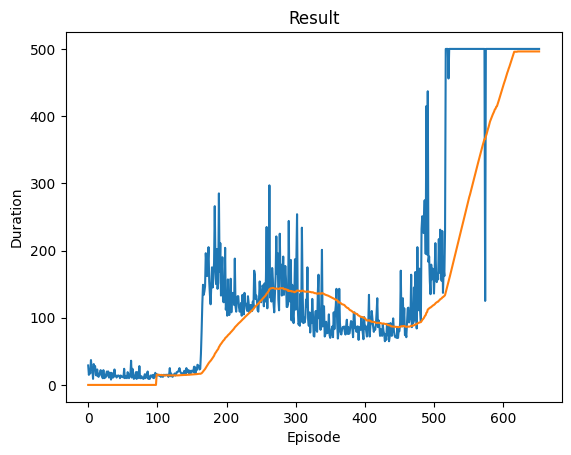
\
**Figure 1. DQN in CartPole**

**1. Visualize and Compare Performance**


*   **CartPole:**
  *   **In Figure 1:**
      *   DQN performs excellently in the CartPole environment.
      *   Around episode 300, the performance is unstable, but by episodes 500 to 600, the reward curve steepens.
      *   This improvement is likely due to DQN using past experience (experience replay), making it better at predicting optimal actions.
      *   Since CartPole is a discrete action space task and DQN is a discrete algorithm, this makes DQN highly suitable for CartPole.









**2. Data Efficiency**

*   **Data Efficiency**
    *   DQN is a discrete algorithm, which means it can use experiences gathered from past episodes and store them in a replay buffer to update its Q-values. As you can see in Figure 1, the performance starts low but rapidly improves as the model gets better at predicting the optimal actions for given states. DQN is generally more sample-efficient because it uses experience replay, which allows it to recycle and learn from old transitions multiple times. This reuse of data makes DQN capable of extracting more learning from fewer episodes. DQN's data efficiency is one of its strong suits, but it comes with the downside of being more challenging to stabilize, especially in environments with large state spaces or continuous actions.










**3. Strength and Weakness of the algorithm**

  *   **Strength:** High data efficiency, especially in discrete action environments.
  *   **Weakness:** Can be unstable


**4. Summary and Reflection**


*   **DQN** is effective in **discrete action spaces** and offers faster learning when **data efficiency** is critical. However, it can **struggle with stability**, especially in complex or continuous environments.

*    In the future, I plan to do experiment with **modifying** other parameters, such as the **learning rate** and **update rate**, to determine whether these adjustments can **enhance the algorithms' performance**. Additionally, if needed once some parameters changed, I plan to **increase the number of episodes** to see if the performance improves with extended training. 





